# Libraries

In [17]:
# general utilities
#from general_utils import utils
#from generalutils import generalutils
#from GeneralUtils import GeneralUtils
import pickle

# data manipulation
import pandas as pd
import numpy as np
import missingno as msno

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier

# machine learning
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss

# model calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

# Helper Functions

In [2]:
# instantiates the utilities object
#gu = Utilities()

# disable max columns limit
pd.set_option('display.max_columns', 70)

# sets to not crop long vlaues for rows
pd.set_option("display.max_colwidth", 70)

# sets format to suppress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# sets seaborn default style
sns.set()

# sets global SEED
SEED = 42

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
    
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Loading Data

In [3]:
pwd

'/Users/lucasquemelli/Documents/repos/cardio_catch_disease'

In [4]:
data = pd.read_csv('/Users/lucasquemelli/Documents/repos/cardio_catch_disease/cardio_train.csv')
data.head()

,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


In [5]:
data = pd.read_csv('/Users/lucasquemelli/Documents/repos/cardio_catch_disease/cardio_train.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.00,100,60,1,1,0,0,0,0


# 1. Data Description

In [6]:
df1 = data.copy()

## 1.1. Data Fields Meaning

There are 3 types of input features:

1. Objective: factual information;
2. Examination: results of medical examination;
3. Subjective: information given by the patient.

Features:

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

## 1.2. Data Dimensions

In [7]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


## 1.3. Data Types

In [8]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [10]:
df1.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.00,130,70,3,1,0,0,0,1


### 1.3.1. Data Conversion

In [11]:
df1["age"] = df1["age"].apply(lambda x: round(x/365))
df1.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.00,110,80,1,1,0,0,1,0
1,1,55,1,156,85.00,140,90,3,1,0,0,1,1
2,2,52,1,165,64.00,130,70,3,1,0,0,0,1


## 1.4. NA Check

In [14]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [15]:
df1.isna().sum()/len(df1)

id            0.00
age           0.00
gender        0.00
height        0.00
weight        0.00
ap_hi         0.00
ap_lo         0.00
cholesterol   0.00
gluc          0.00
smoke         0.00
alco          0.00
active        0.00
cardio        0.00
dtype: float64

<AxesSubplot:>

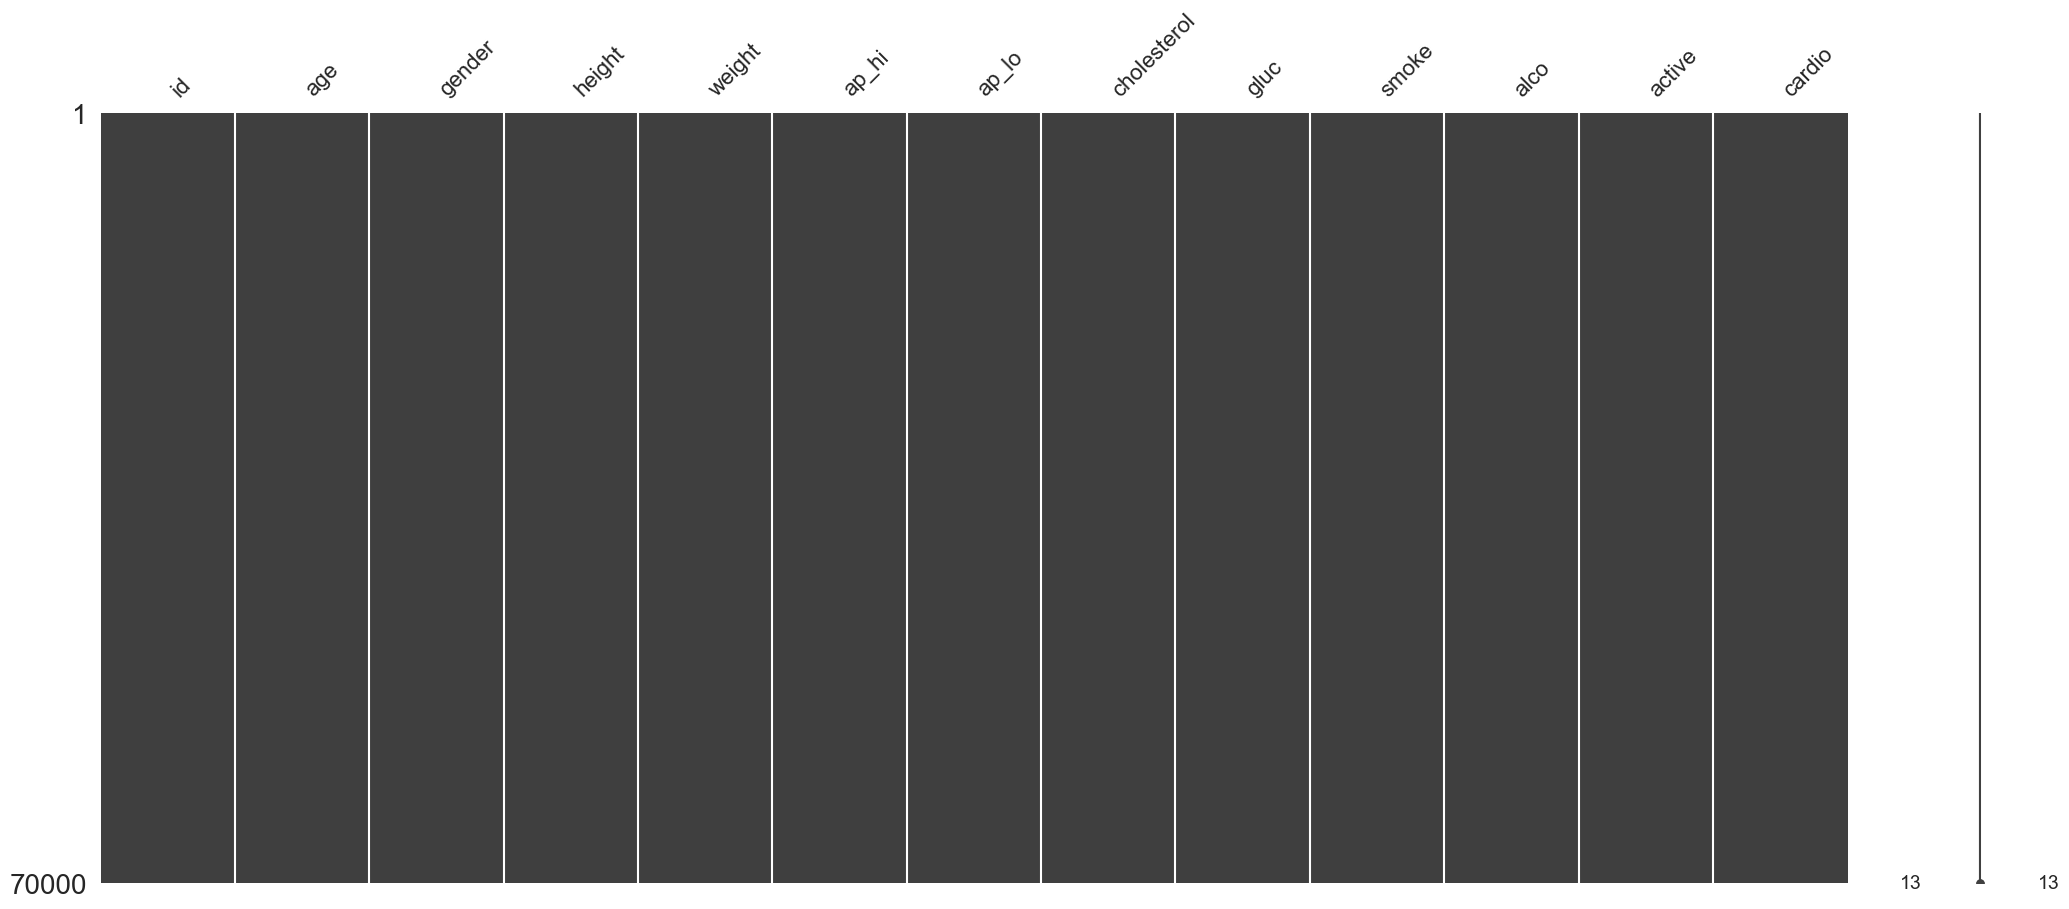

In [18]:
# Visualizing the missing values
msno.matrix(df1)

- 70000 rows.
- 13 columns.
- No missing values.

## 1.6. Descriptive Statistics

This section is to find inconsistencies and anomalies and also the main characteristics of our data.

In [21]:
df1.drop(columns="id").describe().T

,count,mean,std,min,25%,50%,75%,max
age,"70,000.00",53.34,6.77,30.00,48.00,54.00,58.00,65.00
gender,"70,000.00",1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,"70,000.00",164.36,8.21,55.00,159.00,165.00,170.00,250.00
weight,"70,000.00",74.21,14.40,10.00,65.00,72.00,82.00,200.00
ap_hi,"70,000.00",128.82,154.01,-150.00,120.00,120.00,140.00,"16,020.00"
ap_lo,"70,000.00",96.63,188.47,-70.00,80.00,80.00,90.00,"11,000.00"
cholesterol,"70,000.00",1.37,0.68,1.00,1.00,1.00,2.00,3.00
gluc,"70,000.00",1.23,0.57,1.00,1.00,1.00,1.00,3.00
smoke,"70,000.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00
alco,"70,000.00",0.05,0.23,0.00,0.00,0.00,0.00,1.00


Since we have no categorical features, let's just create a numerical dataset without id column:

In [22]:
num_attributes = df1.drop(columns="id").select_dtypes(include=['int64', 'float64'])

### 1.6.1. Numerical Attributes

In [23]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,30.00,65.00,35.00,53.34,54.00,6.77,-0.31,-0.82
1,gender,1.00,2.00,1.00,1.35,1.00,0.48,0.63,-1.60
2,height,55.00,250.00,195.00,164.36,165.00,8.21,-0.64,7.94
3,weight,10.00,200.00,190.00,74.21,72.00,14.40,1.01,2.59
4,ap_hi,-150.00,"16,020.00","16,170.00",128.82,120.00,154.01,85.30,"7,580.07"
5,ap_lo,-70.00,"11,000.00","11,070.00",96.63,80.00,188.47,32.11,"1,425.91"
6,cholesterol,1.00,3.00,2.00,1.37,1.00,0.68,1.59,0.99
7,gluc,1.00,3.00,2.00,1.23,1.00,0.57,2.40,4.29
8,smoke,0.00,1.00,1.00,0.09,0.00,0.28,2.91,6.44
9,alco,0.00,1.00,1.00,0.05,0.00,0.23,3.96,13.66


- From the table above, we may see that we have strong skewness to the left for ap_ho and for ap_lo. 
- The two columns also presented a high peak for their distribution, since we have high values for kurtosis.
- We expected the skewness for the two columns mentioned because they the ones which the mean and the median most vary from each other.
- 250 cm as the maximum height is not possible.
- Minimum value for height of 55 cm is totally possible. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


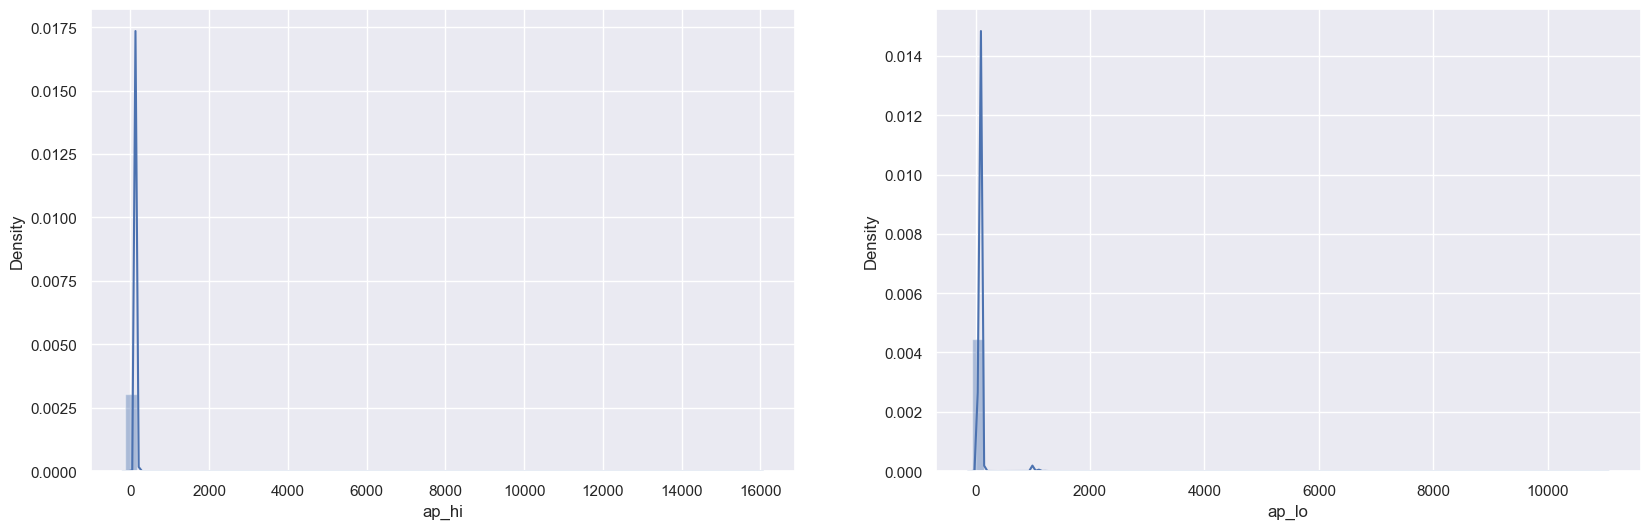

In [24]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["ap_hi"])

plt.subplot(122)
sns.distplot(df1["ap_lo"])

plt.subplots_adjust(wspace = 0.2)

We probably had a left skew because of the maximum values for these variables. Let's see how the distribution is without values higher than those found in 75% (third quartile).

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


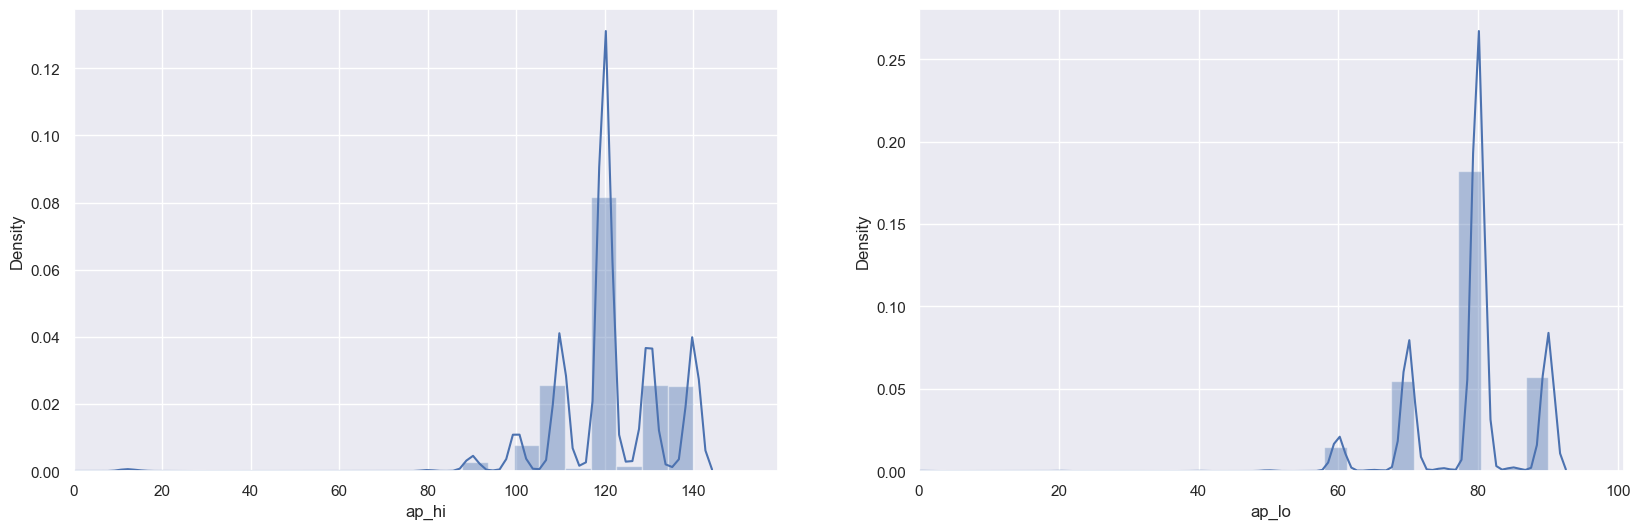

In [28]:
aux = df1[(df1["ap_hi"] <= 140) & (df1["ap_lo"] <= 90)]

plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(aux["ap_hi"])
plt.xlim(0, )

plt.subplot(122)
sns.distplot(aux["ap_lo"])
plt.xlim(0, )

plt.subplots_adjust(wspace = 0.2)

In [31]:
# Selecting data considering the analysis
df1 = df1[(df1["height"] < 250) & (df1["ap_hi"] <= 140) & (df1["ap_lo"] <= 90)]

## 1.7. Checking Outliers

### 1.7.1. Skewness and Kurtosis Classification

Besides the data cleaning we made above, it is still to check outliers in the dataset. Let's classify skewness and kurtosis. 

- Nearly symmetric: Skewness values between -0.5 and 0.5 indicate a nearly symmetric distribution.
- Moderately skewed: Skewness values between -1 and -0.5 or between 0.5 and 1 indicate a moderately skewed distribution.
- Highly skewed: Skewness values less than -1 or greater than 1 indicate a highly skewed distribution.

- The range of values for a classification as heavy tail in terms of kurtosis depends on the specific field or discipline and the context in which it is being used. Generally speaking, kurtosis measures the heaviness of the tails of a probability distribution relative to a normal distribution. A kurtosis value of 3 indicates that the distribution has the same tail weight as a normal distribution, while values greater than 3 indicate heavier tails (in general).

In [39]:
# creating a copied dataframe
summary_stats = ct.copy()

# classifies skwewness
summary_stats['skwewness_class'] = summary_stats['skew'].apply(lambda x: 
                                                               'nearly symmetric' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                                                                else 'moderately skewed' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                                                                else 'highly skewed')

# classifies kurtosis
summary_stats['kurtosis_class'] = summary_stats['kurtosis'].apply(lambda x:
                                                                 'heavy tails' if (x > 3) 
                                                                  else 'light tails')

# checks operations
summary_stats

,attributes,min,max,range,mean,median,std,skew,kurtosis,skwewness_class,kurtosis_class
0,age,30.00,65.00,35.00,53.34,54.00,6.77,-0.31,-0.82,nearly symmetric,light tails
1,gender,1.00,2.00,1.00,1.35,1.00,0.48,0.63,-1.60,moderately skewed,light tails
2,height,55.00,250.00,195.00,164.36,165.00,8.21,-0.64,7.94,moderately skewed,heavy tails
3,weight,10.00,200.00,190.00,74.21,72.00,14.40,1.01,2.59,highly skewed,light tails
4,ap_hi,-150.00,"16,020.00","16,170.00",128.82,120.00,154.01,85.30,"7,580.07",highly skewed,heavy tails
5,ap_lo,-70.00,"11,000.00","11,070.00",96.63,80.00,188.47,32.11,"1,425.91",highly skewed,heavy tails
6,cholesterol,1.00,3.00,2.00,1.37,1.00,0.68,1.59,0.99,highly skewed,light tails
7,gluc,1.00,3.00,2.00,1.23,1.00,0.57,2.40,4.29,highly skewed,heavy tails
8,smoke,0.00,1.00,1.00,0.09,0.00,0.28,2.91,6.44,highly skewed,heavy tails
9,alco,0.00,1.00,1.00,0.05,0.00,0.23,3.96,13.66,highly skewed,heavy tails


The features with a distribution that is highly skewed with heavy tails are:

1. ap_hi.
2. ap_lo.
3. gluc.
4. smoke.
5. alco.

This means that there are many data far from the mean. They could be outliers.

### 1.7.2. Scatterplot Classification

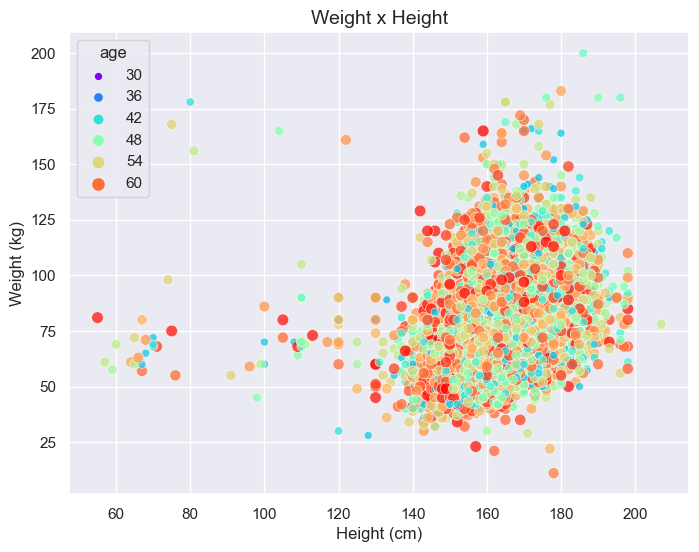

In [40]:
# sets plot size
plt.figure(figsize=(8,6))

# plots scatterplot
sns.scatterplot(x='height', y='weight', data=df1, hue='age', palette='rainbow', size='age', alpha=0.75)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Height", fontsize=14)

# displays the plot
plt.show()

May be outliers:

- Height lower than 120 cm.
- Weight above 150 kg and below 25 kg.

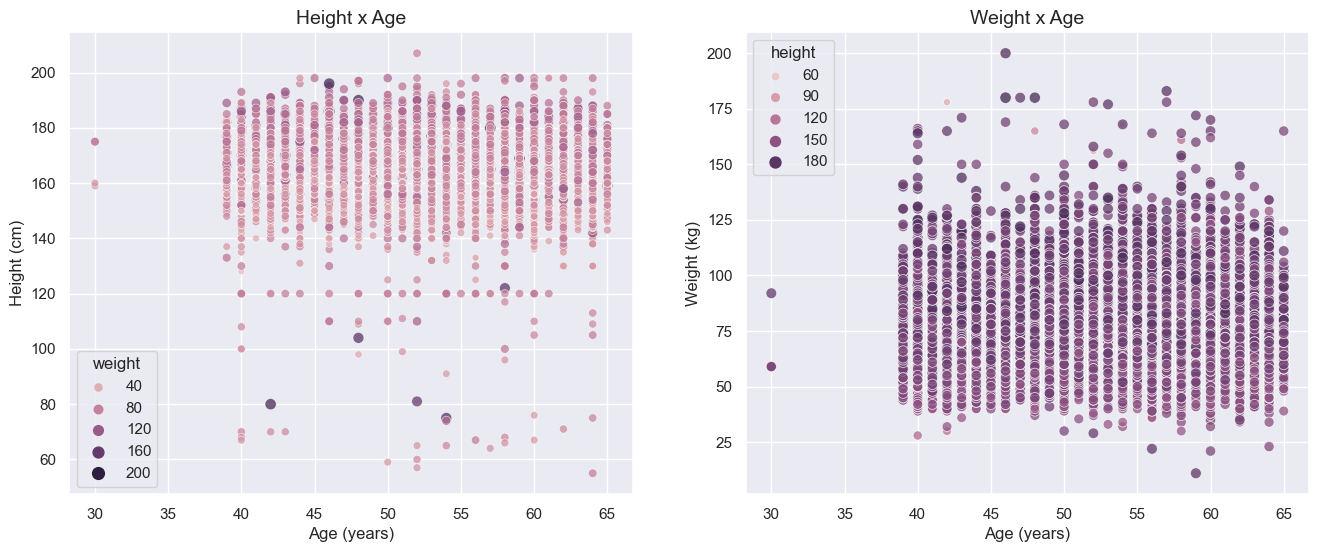

In [41]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='height', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Height (cm)")
plt.title("Height x Age", fontsize=14)

# plots scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x='age', y='weight', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Age", fontsize=14)

# displays the plot
plt.show()

As we mentioned above, outliers may be:

- Height lower than 120 cm. 
- Weight below 25 kg and above 150 kg.

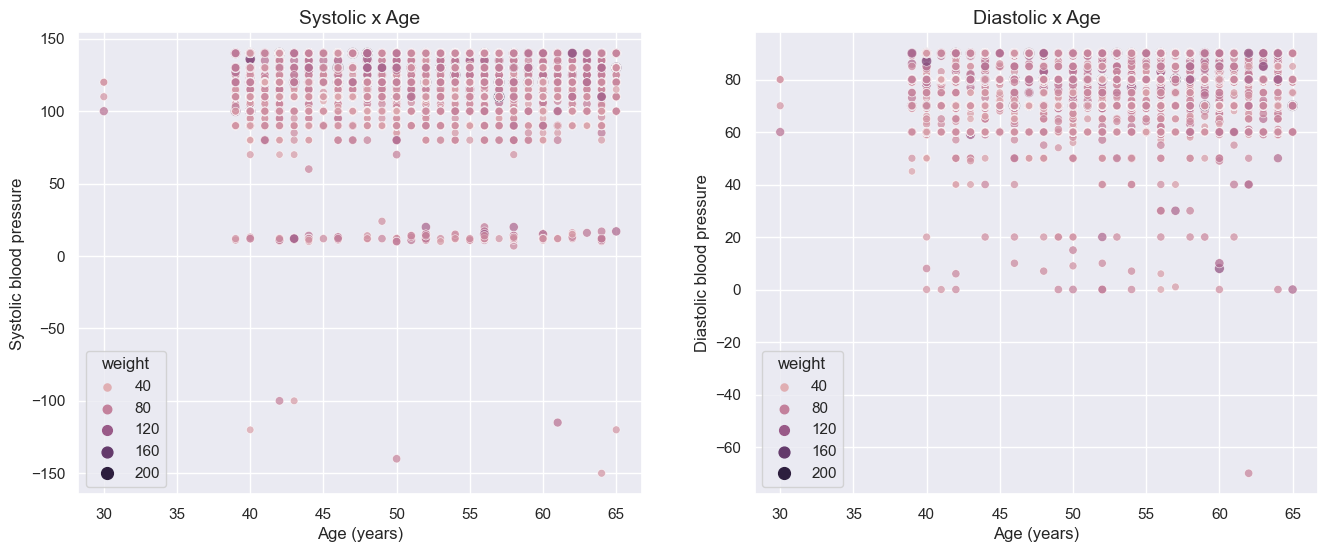

In [48]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Systolic blood pressure")
plt.title("Systolic x Age", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x='age', y='ap_lo', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Diastolic blood pressure")
plt.title("Diastolic x Age", fontsize=14)

# displays the plot
plt.show()

May be outliers:

- Systolic below 90.
- Diastolic below 60.

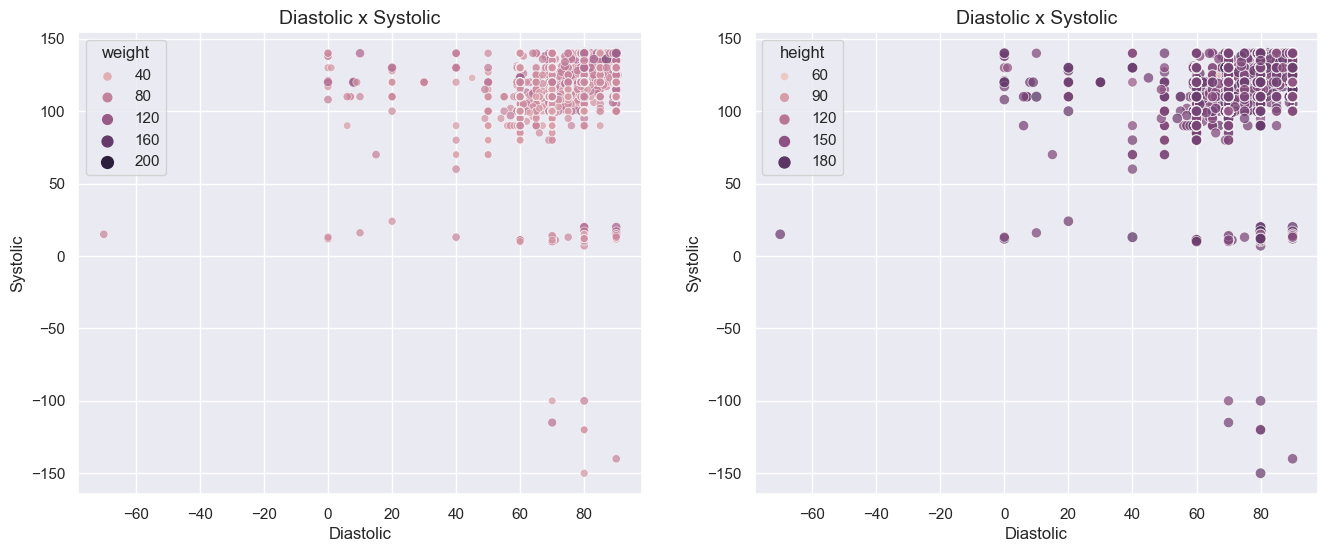

In [47]:
# sets plot size
plt.figure(figsize=(16,6))

plt.subplot(121)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

plt.subplot(122)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

# displays the plot
plt.show()

Conclusions:

- Diastolic below 50 and systolic below 50 may be outliers. 